In [2]:
import pandas as pd 
import numpy as np 
import awswrangler as wr
from datetime import date
import datetime

import mlflow
from mlflow.tracking import MlflowClient

import lightgbm as lgb
import joblib
from sklearn.metrics import roc_auc_score, confusion_matrix

import pickle 

In [3]:
today = date.today()
day, month, year = today.strftime("%d/%m/%Y").split('/')
period = year + month

In [4]:
train = wr.s3.read_parquet("s3://rimac-analytics-temporal/individuals/Dante/cross-sell-veh/data/prec/train/data.parquet")
valid = wr.s3.read_parquet("s3://rimac-analytics-temporal/individuals/Dante/cross-sell-veh/data/prec/valid/data.parquet")


In [5]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'AUC' },
    'num_leaves': 30,
    'min_data_per_group': 200,
    'bagging_freq': 1,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.8,
    'verbose': 1,
    'learning_rate': 0.1, 
    'is_unbalance':True,
    'seed':10
}

exp_name = 'exp_6'
try:
    id_exp = MlflowClient().create_experiment(exp_name,'s3://rimac-analytics-temporal/individuals/Dante/cross-sell-veh/mlruns')
except:
    id_exp = mlflow.get_experiment_by_name(exp_name).experiment_id

with mlflow.start_run(experiment_id=id_exp) as run:
    mlflow.log_params(params)
    
    X_train, y_train = train.drop(['target'], axis=1), train[['target']].astype(int)
    X_val, y_val = valid.drop(['target'], axis=1), valid[['target']].astype(int)

    mlflow.log_param('columnas', X_train.columns)
    
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_val, y_val, reference=train_set)
    
    clf = lgb.train(
        params,
        train_set,
        num_boost_round=500,
        valid_sets=val_set,
        early_stopping_rounds=20,
        verbose_eval=0,
        )
    
    y_trn_pred = clf.predict(X_train, num_iteration=clf.best_iteration)
    y_val_pred = clf.predict(X_val, num_iteration=clf.best_iteration)
    
    trn_auc = roc_auc_score(y_train, y_trn_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)
        
    print(f'Train AUC: {100*trn_auc:.2f} | '
              f'Val AUC: {100*val_auc:.2f} | '
              f'Train Gini: {(100*trn_auc-50)*2:.2f} | '
              f'Val Gini: {(100*val_auc-50)*2:.2f}')
        
    mlflow.log_metric('train_auc', trn_auc)
    mlflow.log_metric('val_auc', val_auc)
    mlflow.sklearn.log_model(clf, 'model')

    df_val = pd.DataFrame()
    df_val['pred'] = y_val_pred
    df_val['target'] = y_val.target.reset_index(drop=True)
    df_val['decile'], cuts= pd.qcut(y_val_pred, 10, duplicates='drop', retbins=True)
    np.save('cuts.npy', cuts)
    mlflow.log_artifact('cuts.npy')
    
    mlflow.set_tag('period_train', period)
    
    print()
    print(f"artifact_uri={mlflow.get_artifact_uri()}")
    
mlflow.end_run()

[LightGBM] [Info] Number of positive: 98846, number of negative: 583521
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2752
[LightGBM] [Info] Number of data points in the train set: 682367, number of used features: 28


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.144858 -> initscore=-1.775517
[LightGBM] [Info] Start training from score -1.775517
Train AUC: 97.87 | Val AUC: 97.42 | Train Gini: 95.74 | Val Gini: 94.84

artifact_uri=s3://rimac-analytics-temporal/individuals/Dante/cross-sell-veh/mlruns/d6cf05ee621949eaba286b3efc53e93d/artifacts


In [7]:
np.median(y_trn_pred)

0.033890372690139135

In [8]:
train['pred'] = y_trn_pred

<AxesSubplot:>

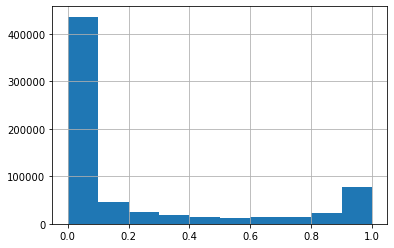

In [9]:
train.pred.hist()

<AxesSubplot:>

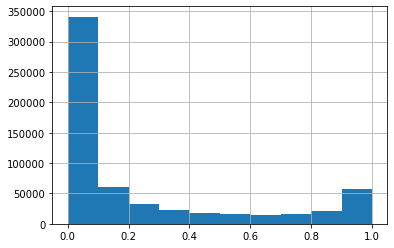

In [68]:
train.pred.hist()

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
sc = StandardScaler()

In [ ]:
sc.fit(distribucio)

In [ ]:
sc.transform()

In [62]:
df_val.groupby('decile').agg({'target': ['mean', 'count']})

target       
                          mean  count
decile                               
(-0.000985, 0.00533]  0.000398  15060
(0.00533, 0.0111]     0.001062  15059
(0.0111, 0.0206]      0.001461  15059
(0.0206, 0.0372]      0.002789  15059
(0.0372, 0.0664]      0.007371  15059
(0.0664, 0.125]       0.014941  15059
(0.125, 0.255]        0.035062  15059
(0.255, 0.544]        0.103925  15059
(0.544, 0.891]        0.378046  15059
(0.891, 1.0]          0.879814  15060

In [64]:
df_val.target.mean()

0.1424909689757756

In [65]:
df_val.shape

(150592, 3)

In [61]:
cuts

array([1.49895563e-05, 5.33033580e-03, 1.11263409e-02, 2.06319170e-02,
       3.71802842e-02, 6.63849774e-02, 1.24757035e-01, 2.55074497e-01,
       5.43542687e-01, 8.91139470e-01, 9.99757476e-01])